## tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)                                             
#### 第一个参數input：指需要做卷積的输入图像，它要求是一个Tensor，具有[batch, in_height, in_width, in_channels]这樣的shape，具體含意是[訓練時一个batch的圖片数量, 圖片高度, 圖片宽度, 圖像通道數]，注意這是一個4维的Tensor，要求類型为float32和float64其中之一
#### 第二个参數filter：相当于CNN中的卷積核，它要求是一个Tensor，具有[filter_height, filter_width, in_channels, out_channels]這樣的shape，具體含意是[卷積核的高度，卷積核的宽度，圖像通道數，卷積核個數]，要求類型与参數input相同，有一个地方需要注意，第三维in_channels，就是参数input的第四维
#### 第三个参数strides：卷積時在圖像每一维的步長，这是一個一维的向量，長度4
#### 第四个参数padding：string類型的量，只能是"SAME","VALID"其中之一，这個值决定了不同的卷積方式（後面會介绍）
#### 第五个参数：use_cudnn_on_gpu:bool类型，是否使用cudnn加速，默认为true

结果返回一個Tensor，這個输出，就是我们常说的feature map
來源：https://blog.csdn.net/mao_xiao_feng/article/details/53444333?utm_source=copy 

## tf.nn.max_pool(value, ksize, strides, padding, name=None)
參數是四個，和卷積很類似：

#### 第一個參數value：需要池化的輸入，一般池化層接在卷積層後面，所以輸入通常是feature map，依然是[batch, height, width, channels]这样的shape
#### 第二個參數ksize：池化窗口的大小，取一個四維向量，一般是[1, height, width, 1]，因为我们不想在batch和channels上做池化，所以這两个维度設為了1
#### 第三個參數strides：和卷積類似，窗口在每一個維度上滑動的步長，一般也是[1, stride,stride, 1]
#### 第四個參數padding：和卷積類似，可以取'VALID'或者'SAME'
返回一個Tensor，類型不變，shape仍然是[batch, height, width, channels]這種形式


來源：https://blog.csdn.net/mao_xiao_feng/article/details/53453926?utm_source=copy 

In [1]:
import tensorflow as tf


class my_Conv_Pool():
    def __init__(self, data, kernel=[5, 5], depth=16, cp_layers=2,
                       conv_strides=[1,1,1,1], pool_ksize=[1,2,2,1], pool_strides=[1,2,2,1]):
        
        # image
        self.images = data
        self.cp_layers = cp_layers            # 做幾層covolution和pooling
        
        # conolution參數
        self.in_height_width = [self.images.shape[1], self.images.shape[2]]
        self.in_channels = self.images.shape[3]        # Number of colors in the image (greyscale)
        self.filter_height_width = kernel        # Convolutional Kernel size
        self.out_channels = depth                # Convolutional Kernel depth size == Number of Convolutional Kernels
        self.conv_strides = conv_strides
        
        # Pooling參數
        self.pool_ksize = pool_ksize
        self.pool_strides = pool_strides
        
        # 儲存Convolution和Pooling的資料
        self.Layer = dict()
        self.i = 1           # conv數量
        self.j = 1           # pool數量
        self.k = 1           # 總layer數量
    
        # 輸入圖片的大小
        in_height = self.in_height_width[0]
        in_width = self.in_height_width[1]
        
        # placeholder
        self.X = tf.placeholder(tf.float64, shape=(None, in_height, in_width, self.in_channels))
        self.output_layer = self.X
        #self_Y = tf.placeholder(tf.float64, shape=(None, ))           # feature map
        
    
    # Convolution+RELU
    def Convolution2D(self):
        filter_height = self.filter_height_width[0]
        filter_width = self.filter_height_width[1]
        
        weight = tf.Variable(tf.truncated_normal([filter_height, filter_width, self.in_channels, self.out_channels],
                                                  stddev=0.1, dtype=tf.float64))
        bias = tf.Variable(tf.constant(1.0, shape=[self.out_channels], dtype=tf.float64))
            
        conv = tf.nn.conv2d(self.output_layer, weight, self.conv_strides, padding='SAME')       # feature map
        conv = tf.nn.relu(conv + bias)                                               # relu
        
        
        # 儲存資料
        self.Layer['Layer'+str(self.k)+'_Conv'+str(self.i)] = conv
        
        # 更新參數
        self.in_channels = self.out_channels
        self.out_channels = self.out_channels + self.out_channels
        self.i += 1
        self.k += 1
        self.output_layer = conv
        
        
    # Max Pooling
    def MaxPooling(self):
        pool = tf.nn.max_pool(self.output_layer, self.pool_ksize, self.pool_strides, padding='SAME')
        
        
        # 儲存資料
        self.Layer['Layer'+str(self.k)+'_Pool'+str(self.j)] = pool
        
        # 更新參數
        self.output_layer = pool
        self.j += 1
        self.k += 1
        
    
    # Convolution + Max_Pooling
    def conv_pool(self):
        filter_height = self.filter_height_width[0]
        filter_width = self.filter_height_width[1]
        
        # Convolution and Pooling
        for i in range(self.cp_layers):
            # 權重偏移量
            weight = tf.Variable(tf.truncated_normal([filter_height, filter_width, self.in_channels, self.out_channels],
                                                     stddev=0.1, dtype=tf.float64))
            bias = tf.Variable(tf.constant(1.0, shape=[self.out_channels], dtype=tf.float64))
            
            conv = tf.nn.conv2d(self.output_layer, weight, self.conv_strides, padding='SAME')         # feature map
            conv = tf.nn.relu(conv + bias)                                                       # relu
            pool = tf.nn.max_pool(conv, self.pool_ksize, self.pool_strides, padding='SAME')
            
            
             # 儲存conv和pool資料
            self.Layer['Layer'+str(self.k)+'_Conv'+str(self.i)] = conv
            self.k += 1
            self.Layer['Layer'+str(self.k)+'_Pool'+str(self.j)] = pool
            
            # 更新參數
            self.in_channels = self.out_channels
            self.out_channels = self.out_channels + self.out_channels
            self.output_layer = pool
            self.i += 1
            self.j += 1
            self.k += 1
        
    
    def show(self, layer=0, tag='Conv1'):
        
        
        if layer > 0:
            output_layer = self.Layer['Layer'+str(layer)+'_'+tag]
        else:
            output_layer = self.output_layer
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            output = sess.run(output_layer, feed_dict={self.X:self.images})
            return output
            
    
    def set_input_placeholder(self, in_channelsinput_placeholder):
        self.input_placeholder = input_placeholder
        return self.input_placeholder
    
    def set_filter_height_width(self, filter_height_width):
        self.filter_height_width = filter_height_width
        return self.filter_height_width
    
    def set_out_channels(self, out_channels):
        self.out_channels = out_channels
        return self.out_channels
    
    def set_conv_strides(self, conv_strides):
        self.conv_strides = conv_strides
        return self.conv_strides
    
    def set_pool_ksize(self, pool_ksize):
        self.pool_ksize= pool_ksize
        return self.pool_ksize
    
    def set_pool_strides(self, pool_strides):
        self.pool_strides= pool_strides
        return self.pool_strides
    
    def print_layers(self):
        for key in self.Layer:
            print(key + '：' + str(self.Layer[key]))

C:\Users\Ncuee_lab418\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
import numpy as np
I = cv2.imread('Lenna.jpg')
I.shape

(200, 200, 3)

In [3]:
image = np.zeros([1,200,200,3])
image.shape

(1, 200, 200, 3)

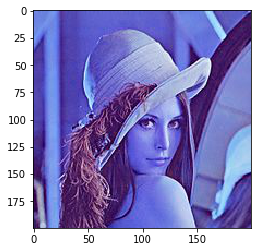

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

image[0,:,:,:] = I
image[0,:,:,:] = image[0,:,:,:].astype(np.uint8)
plt.imshow(image[0,:,:,:].astype(np.uint8))

## 測試輸出結果

In [5]:
#data = image
feature = my_Conv_Pool(image,depth=7, cp_layers=2)

In [6]:
feature.Convolution2D()
feature.Convolution2D()
feature.Convolution2D()
feature.Convolution2D()
feature.MaxPooling()
feature.Convolution2D()
feature.MaxPooling()
feature.conv_pool()
feature.print_layers()

Layer1_Conv1：Tensor("Relu:0", shape=(?, 200, 200, 7), dtype=float64)
Layer2_Conv2：Tensor("Relu_1:0", shape=(?, 200, 200, 14), dtype=float64)
Layer3_Conv3：Tensor("Relu_2:0", shape=(?, 200, 200, 28), dtype=float64)
Layer4_Conv4：Tensor("Relu_3:0", shape=(?, 200, 200, 56), dtype=float64)
Layer5_Pool1：Tensor("MaxPool:0", shape=(?, 100, 100, 56), dtype=float64)
Layer6_Conv5：Tensor("Relu_4:0", shape=(?, 100, 100, 112), dtype=float64)
Layer7_Pool2：Tensor("MaxPool_1:0", shape=(?, 50, 50, 112), dtype=float64)
Layer8_Conv6：Tensor("Relu_5:0", shape=(?, 50, 50, 224), dtype=float64)
Layer9_Pool3：Tensor("MaxPool_2:0", shape=(?, 25, 25, 224), dtype=float64)
Layer10_Conv7：Tensor("Relu_6:0", shape=(?, 25, 25, 448), dtype=float64)
Layer11_Pool4：Tensor("MaxPool_3:0", shape=(?, 13, 13, 448), dtype=float64)


(1, 13, 13, 448)


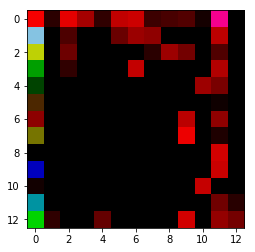

In [7]:
a = feature.show()
print(a.shape)
plt.imshow(a[0,:,:,0:3].astype(np.uint8))

## 查看中間層數的圖

(1, 200, 200, 28)


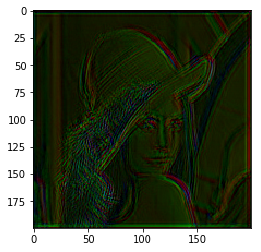

In [8]:
b = feature.show(layer=3, tag='Conv3')
print(b.shape)
plt.imshow(b[0,:,:,0:3].astype(np.uint8))

(1, 200, 200, 56)


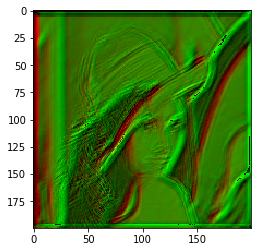

In [9]:
c = feature.show(layer=4, tag='Conv4')
print(c.shape)
plt.imshow(c[0,:,:,0:3].astype(np.uint8))

(1, 100, 100, 56)


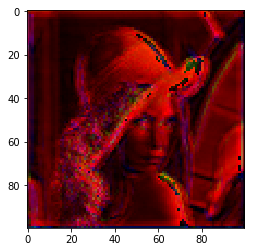

In [10]:
d = feature.show(layer=5, tag='Pool1')
print(d.shape)
plt.imshow(d[0,:,:,0:3].astype(np.uint8))

(1, 50, 50, 224)


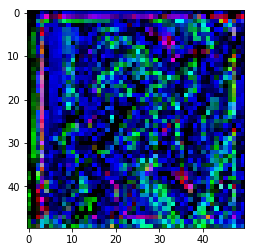

In [11]:
e = feature.show(layer=8, tag='Conv6')
print(e.shape)
plt.imshow(e[0,:,:,0:3].astype(np.uint8))